In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [349]:
df = pd.read_csv("paragrapghs_with_topisc_2022.csv.zip", index_col=0)
df.head()

,Unnamed: 0.1,rsspp_index,index,company,paragraph,original_text,cleaned_text,year,Экология в целом,Климат,...,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,cleaned_texttopics,second_max_topic_cos,second_max_score_cos,max_topic_exp,max_score_exp,second_max_topic_exp,second_max_score_exp,total_found_words
0,0,1428,1428,ЭЛ5-Энерго 2022,42,алибек айбекович тналин генеральный директор э...,алибек айбекович тналин генеральный директор у...,2020,0.0,0.0,...,0.0,0.0,алибек айбекович тналин генеральный директор у...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1428,1428,ЭЛ5-Энерго 2022,43,"в завершение хочу еще раз отметить, что данные...",завершение хотеть отметить дать достижение явл...,2020,0.0,0.0,...,2.0,2.0,завершение хотеть отметить дать достижение явл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1428,1428,ЭЛ5-Энерго 2022,47,представляем вашему вниманию наш второй отчет ...,представлять ваш внимание наш второй отчёт уст...,2020,0.0,0.0,...,1.0,3.0,представлять ваш внимание наш второй отчёт уст...,NaN,NaN,Обучение и развитие,-39223.0,Социальные инвестиции и благотв,-40520.0,26.0
3,3,1428,1428,ЭЛ5-Энерго 2022,48,наша гордость в 2022 году достижение показател...,наш гордость 2022 год достижение показатель но...,2020,0.0,0.0,...,0.0,0.0,наш гордость 2022 год достижение показатель но...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1428,1428,ЭЛ5-Энерго 2022,50,мы прилагаем большие усилия для развития и мот...,прилагать больший усилие развитие мотивация со...,2020,0.0,0.0,...,0.0,1.0,прилагать больший усилие развитие мотивация со...,NaN,NaN,Сотрудники. Безопасность и охра,-136036.0,Экология в целом,-144720.0,57.0


In [50]:
df["company"].unique()

array(['ЭЛ5-Энерго 2022', 'Центр Корпоративной Медицины', 'Акрон 2022',
       'ГК Дело 2022', 'ВТБ 2022',
       '«Общероссийское отраслевое объединение работодателей электроэнергетики',
       'ПАО «Северсталь', 'Селигдар 2022', 'ПАО ММК 2022', 'Евраз 2022',
       'ДОМ.РФ', 'АО «Калининградский янтарный комбинат',
       'ПАО «ГМК «Норильский никель', 'Глобалтранс', 'ВК 2022'],
      dtype=object)

In [29]:
df.loc[df["company"] == "reports/ПАО «ВЫМПЕЛКОМ» ", ["company"]] = "reports/ПАО «ВЫМПЕЛКОМ»"

In [350]:
not_nan = df[df["max_topic_exp"].notna()]
# число абзацев соотвествующих теме
reports = not_nan.groupby(["company", "index", "max_topic_exp"])["index"].count()
reports.head()

company                                                                   index  max_topic_exp                  
«Общероссийское отраслевое объединение работодателей электроэнергетики  812    Биоразнообразие                     1
                                                                                 Закупки и антикоррупция             1
                                                                                 Обучение и развитие                73
                                                                                 Оплата труда                       33
                                                                                 Потребители. Качество и безопас     9
Name: index, dtype: int64

# TF-IDF

## TF

In [327]:
topics_per_report = not_nan.groupby("index")["index"].count()
topics_per_report.head()

index
0        99
1       197
319    1140
505      32
812     293
Name: index, dtype: int64

In [328]:
tf = defaultdict(dict)
for (file_name, index, topic), row in reports.items():
    tf[index][topic] = row / topics_per_report[index]
tf = pd.DataFrame(tf).T

## IDF

In [329]:
idf = {}
for topic in df["max_topic_exp"].unique():
    if pd.isna(topic):
        continue
    idf[topic] = np.log(df["index"].nunique() / tf[topic].notna().sum())
idf = pd.Series(idf)

In [330]:
tf_idf = defaultdict(dict)
for idx, row in tf.iterrows():
    for topic in row.index:
        tf_idf[idx][topic] = row[topic] * idf[topic]

In [331]:
tf_idf = pd.DataFrame(tf_idf).T
tf_idf = tf_idf.fillna(0)
tf_idf.head()

,Биоразнообразие,Закупки и антикоррупция,Обучение и развитие,Оплата труда,Потребители. Качество и безопас,Сотрудники. Безопасность и охра,Сотрудники. Здоровье и благопол,Сотрудники. Наем и увольнение,Сотрудники. Профсоюз и Коллекти,Социальные инвестиции и благотв,...,Климат,Поставщики в целом,Потребители. Удовлетворенность,Сотрудники. Волонтерство,Сотрудники. Вовлеченность и мот,Рекультивация земель,Сотрудники. Корпоративная культ,Потребители. Здоровье и благопо,Корпоративное управление,Потребители. Ценовая политика
812,0.001059,0.001059,0.017189,0.025132,0.002119,0.012480,0.005372,0.018485,0.060165,0.000706,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
505,0.000000,0.000000,0.012936,0.000000,0.002156,0.004312,0.008944,0.000000,0.000000,0.008624,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1420,0.001945,0.011667,0.009733,0.002798,0.005191,0.010598,0.004037,0.000000,0.006995,0.003244,...,0.008897,0.009723,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1421,0.000000,0.000000,0.006899,0.000000,0.006899,0.013799,0.000000,0.000000,0.000000,0.006899,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1422,0.003485,0.007667,0.013644,0.003009,0.004806,0.002326,0.000965,0.000000,0.001504,0.003566,...,0.005467,0.011152,0.003425,0.006086,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
tf_idf.to_csv("tf_idf_2022.csv")

In [87]:
# ???
raex_scores = pd.read_csv("raex_test1_mini.csv", index_col=0)
raex_scores

,Название,ESG-рейтинг,E Rank,S Rank,G Rank,G-рейтинг,E_transformed,S_transformed,G_transformed
1424,ЕВРАЗ,BBB,19,38,13,AA,5,5,2
1080,«Сахалинская энергия»,BBB,22,22,54,BBB,5,4,4
985,«Россети»,BBB,25,37,41,A,5,5,3
1420,"«Акрон», группа",BB,66,51,43,A,7,5,3
1422,Банк ВТБ,BB,50,41,101,BB,7,5,5
1421,VK,B,60,71,82,BB,7,6,5
190,Альфа-Банк,B,74,61,71,BBB,8,6,4
397,«Газпром нефть»,CC,113,139,133,CCC,9,8,7


In [58]:
tf_idf

,Биоразнообразие,Закупки и антикоррупция,Обучение и развитие,Оплата труда,Потребители. Качество и безопас,Сотрудники. Безопасность и охра,Сотрудники. Здоровье и благопол,Сотрудники. Наем и увольнение,Сотрудники. Профсоюз и Коллекти,Социальные инвестиции и благотв,...,Климат,Поставщики в целом,Потребители. Удовлетворенность,Сотрудники. Волонтерство,Сотрудники. Вовлеченность и мот,Рекультивация земель,Сотрудники. Корпоративная культ,Потребители. Здоровье и благопо,Корпоративное управление,Потребители. Ценовая политика
812,0.001059,0.001059,0.017189,0.025132,0.002119,0.012480,0.005372,0.018485,0.060165,0.000706,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
505,0.000000,0.000000,0.012936,0.000000,0.002156,0.004312,0.008944,0.000000,0.000000,0.008624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1420,0.001945,0.011667,0.009733,0.002798,0.005191,0.010598,0.004037,0.000000,0.006995,0.003244,...,0.008897,0.009723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1421,0.000000,0.000000,0.006899,0.000000,0.006899,0.013799,0.000000,0.000000,0.000000,0.006899,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1422,0.003485,0.007667,0.013644,0.003009,0.004806,0.002326,0.000965,0.000000,0.001504,0.003566,...,0.005467,0.011152,0.003425,0.006086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1423,0.000685,0.004108,0.011270,0.007389,0.002437,0.010813,0.000948,0.000000,0.002463,0.002894,...,0.011636,0.010270,0.000000,0.000000,0.002023,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001574,0.003149,0.010156,0.002265,0.005954,0.003852,0.002179,0.000000,0.004531,0.007705,...,0.008233,0.011021,0.000000,0.000000,0.000000,0.005577,0.008170,0.000000,0.000000,0.000000
1425,0.001410,0.007754,0.012544,0.003043,0.005488,0.008624,0.002277,0.000000,0.005579,0.002038,...,0.000922,0.017622,0.001732,0.000000,0.000000,0.000000,0.000000,0.006155,0.000000,0.000000
319,0.004625,0.002721,0.013072,0.002740,0.005144,0.004660,0.001130,0.000000,0.004893,0.007383,...,0.004979,0.013875,0.004011,0.000000,0.002411,0.004818,0.001412,0.000000,0.001767,0.000000
1120,0.004438,0.002959,0.009762,0.004967,0.003071,0.006472,0.003185,0.000000,0.003902,0.004607,...,0.010959,0.010848,0.001212,0.000000,0.001457,0.001747,0.000000,0.000000,0.000000,0.004305


In [ ]:
# конец tf-idf???

In [37]:
assert len(tf_idf.index[~tf_idf.index.isin(raex_scores.index)]) == 0, (
    tf_idf.index[~tf_idf.index.isin(raex_scores["компания"])],
    raex_scores[~raex_scores["компания"].isin(tf_idf.index)]["компания"].unique(),
)

KeyError: 'компания'

In [89]:
combined = tf_idf.join(raex_scores[["E_transformed", "S_transformed", "G_transformed"]])

In [90]:
combined = combined.loc[combined['E_transformed'].notna()]

In [91]:
combined

,Биоразнообразие,Вода,Воздух,Закупки и антикоррупция,Климат,Корпоративное управление,Обучение и развитие,Оплата труда,Отношения с инвесторами,Поставщики в целом,...,Потребители. Доступность,Отходы и циклическая экономика,Потребители. Ценовая политика,Потребители. Персональные данны,Малый и локальный бизнес,Отчетность и прозрачность,Экологичность продукта,E_transformed,S_transformed,G_transformed
985,0.001485,0.000990,0.0,0.008767,0.000495,0.008811,0.017144,0.022335,0.003090,0.009404,...,0.003323,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,5.0,5.0,3.0
1080,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,5.0,4.0,4.0
190,0.004408,0.000000,0.0,0.006506,0.004408,0.039235,0.016417,0.000000,0.006880,0.008816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,8.0,6.0,4.0
1420,0.003074,0.004508,0.0,0.012100,0.009222,0.010944,0.012975,0.013871,0.004318,0.009631,...,0.000000,0.001081,0.001824,0.000000,0.000000,0.00000,0.0,7.0,5.0,3.0
1421,0.000000,0.000000,0.0,0.000000,0.010619,0.031507,0.003955,0.000000,0.016575,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,7.0,6.0,5.0
1422,0.003886,0.001829,0.0,0.005399,0.005943,0.000000,0.015921,0.005554,0.003033,0.003886,...,0.009209,0.000000,0.000000,0.001535,0.002431,0.00311,0.0,7.0,5.0,5.0
1424,0.000000,0.000000,0.0,0.000000,0.082452,0.326187,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.217437,0.000000,0.000000,0.000000,0.00000,0.0,5.0,5.0,2.0
397,0.000000,0.033374,0.0,0.000000,0.000000,0.000000,0.006215,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,9.0,8.0,7.0


In [92]:
combined.to_csv("tfidf_with_esg_test1.csv")

In [93]:
topic_words = pd.read_csv("../topic_words.csv", index_col=0)
topic_words.head()

,topic,weight,type,word
meta,,,,
env,Экология в целом,5,0,воздействие
env,Экология в целом,5,0,окружающая среда
env,Экология в целом,5,0,природа
env,Экология в целом,5,0,природоохранный
env,Экология в целом,5,0,экологический


In [57]:
gr = topic_words.groupby("meta")["topic"].apply(set)

In [58]:
topics = set([col.split("_")[0] for col in combined.columns if col.find("_") != -1])
topics = [topic for topic in topics if len(topic) > 1]

In [59]:
for (
    let,
    row,
) in gr.items():
    print(let, len(row))

env 9
gov 10
social 26


In [94]:
letter = {"env": ["E_transformed"], "social": ["S_transformed"], "gov": ["G_transformed"]}
for meta, col_set in gr.items():
    for col in col_set:
        found = False
        for c_col in combined.columns:
            if col in c_col:
                letter[meta].append(c_col)
                found = True
        # if not found:
        #     print(col)
for key, arr in letter.items():
    print(key, len(arr))

env 10
social 23
gov 4


# Fisrt

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def logreg_(data: pd.DataFrame, cur_letter: str):
    model = LogisticRegression()
    y_col = f"{cur_letter}_transformed"
    X = data.drop([y_col], axis=1)
    y = data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"{X_train.shape=} {X_test.shape=}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred, ' PPPP')
    print(y_test)
    print("accuracy_score", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [66]:
def map_to_ranges(value):
    if value <= 3:
        return 1
    elif value <= 6:
        return 2
    else:
        return 3

In [105]:
for cur_letter in ["E", "S", "G"]:
    col = f"{cur_letter}_transformed"
    combined[col] = combined[col].apply(map_to_ranges)

In [36]:
combined

,Биоразнообразие,Вода,Воздух,Закупки и антикоррупция,Климат,Корпоративное управление,Обучение и развитие,Оплата труда,Отношения с инвесторами,Поставщики в целом,...,Потребители. Доступность,Отходы и циклическая экономика,Потребители. Ценовая политика,Потребители. Персональные данны,Малый и локальный бизнес,Отчетность и прозрачность,Экологичность продукта,E_transformed,S_transformed,G_transformed
985,0.001485,0.000990,0.0,0.008767,0.000495,0.008811,0.017144,0.022335,0.003090,0.009404,...,0.003323,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1080,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
190,0.004408,0.000000,0.0,0.006506,0.004408,0.039235,0.016417,0.000000,0.006880,0.008816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1420,0.003074,0.004508,0.0,0.012100,0.009222,0.010944,0.012975,0.013871,0.004318,0.009631,...,0.000000,0.001081,0.001824,0.000000,0.000000,0.00000,0.0,1,1,1
1421,0.000000,0.000000,0.0,0.000000,0.010619,0.031507,0.003955,0.000000,0.016575,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1422,0.003886,0.001829,0.0,0.005399,0.005943,0.000000,0.015921,0.005554,0.003033,0.003886,...,0.009209,0.000000,0.000000,0.001535,0.002431,0.00311,0.0,1,1,1
1424,0.000000,0.000000,0.0,0.000000,0.082452,0.326187,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.217437,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
397,0.000000,0.033374,0.0,0.000000,0.000000,0.000000,0.006215,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1


In [37]:
combined

,Биоразнообразие,Вода,Воздух,Закупки и антикоррупция,Климат,Корпоративное управление,Обучение и развитие,Оплата труда,Отношения с инвесторами,Поставщики в целом,...,Потребители. Доступность,Отходы и циклическая экономика,Потребители. Ценовая политика,Потребители. Персональные данны,Малый и локальный бизнес,Отчетность и прозрачность,Экологичность продукта,E_transformed,S_transformed,G_transformed
985,0.001485,0.000990,0.0,0.008767,0.000495,0.008811,0.017144,0.022335,0.003090,0.009404,...,0.003323,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1080,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
190,0.004408,0.000000,0.0,0.006506,0.004408,0.039235,0.016417,0.000000,0.006880,0.008816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1420,0.003074,0.004508,0.0,0.012100,0.009222,0.010944,0.012975,0.013871,0.004318,0.009631,...,0.000000,0.001081,0.001824,0.000000,0.000000,0.00000,0.0,1,1,1
1421,0.000000,0.000000,0.0,0.000000,0.010619,0.031507,0.003955,0.000000,0.016575,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
1422,0.003886,0.001829,0.0,0.005399,0.005943,0.000000,0.015921,0.005554,0.003033,0.003886,...,0.009209,0.000000,0.000000,0.001535,0.002431,0.00311,0.0,1,1,1
1424,0.000000,0.000000,0.0,0.000000,0.082452,0.326187,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.217437,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1
397,0.000000,0.033374,0.0,0.000000,0.000000,0.000000,0.006215,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1,1,1


In [106]:
for cur_letter, letter_type in [("E", "env"), ("S", "social"), ("G", "gov")]:
    print(cur_letter, letter_type)
    logreg_(combined[letter[letter_type]], cur_letter)

E env
X_train.shape=(6, 9) X_test.shape=(2, 9)
[3 3]  PPPP
1080    2
1422    3
Name: E_transformed, dtype: int64
accuracy_score 0.5
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

S social
X_train.shape=(6, 22) X_test.shape=(2, 22)
[2 2]  PPPP
1080    2
1422    2
Name: S_transformed, dtype: int64
accuracy_score 1.0
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

G gov
X_train.shape=(6, 3) X_test.shape=(2, 3)
[1 1]  PPPP
1080    2
1422    2
Name: G_transformed, dtype: int64
accuracy_score 0.0

/Users/darlinkennedy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darlinkennedy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darlinkennedy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [70]:
combined["E_transformed"].value_counts()

3    5
2    3
Name: E_transformed, dtype: int64

# Second

In [12]:
from pymcdm.methods import TOPSIS

In [59]:
df

,Unnamed: 0.1,rsspp_index,index,company,paragraph,original_text,cleaned_text,year,Экология в целом,Климат,...,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,cleaned_texttopics,second_max_topic_cos,second_max_score_cos,max_topic_exp,max_score_exp,second_max_topic_exp,second_max_score_exp,total_found_words
0,0,1428,1428,ЭЛ5-Энерго 2022,42,алибек айбекович тналин генеральный директор э...,алибек айбекович тналин генеральный директор у...,2020,0.0,0.000000,...,0.0,0.0,алибек айбекович тналин генеральный директор у...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1428,1428,ЭЛ5-Энерго 2022,43,"в завершение хочу еще раз отметить, что данные...",завершение хотеть отметить дать достижение явл...,2020,0.0,0.000000,...,2.0,2.0,завершение хотеть отметить дать достижение явл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1428,1428,ЭЛ5-Энерго 2022,47,представляем вашему вниманию наш второй отчет ...,представлять ваш внимание наш второй отчёт уст...,2020,0.0,0.000000,...,1.0,3.0,представлять ваш внимание наш второй отчёт уст...,NaN,NaN,Обучение и развитие,-39223.0,Социальные инвестиции и благотв,-40520.0,26.0
3,3,1428,1428,ЭЛ5-Энерго 2022,48,наша гордость в 2022 году достижение показател...,наш гордость 2022 год достижение показатель но...,2020,0.0,0.000000,...,0.0,0.0,наш гордость 2022 год достижение показатель но...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1428,1428,ЭЛ5-Энерго 2022,50,мы прилагаем большие усилия для развития и мот...,прилагать больший усилие развитие мотивация со...,2020,0.0,0.000000,...,0.0,1.0,прилагать больший усилие развитие мотивация со...,NaN,NaN,Сотрудники. Безопасность и охра,-136036.0,Экология в целом,-144720.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8400,8400,1421,1421,ВК 2022,25,с помощью этого инструмента можно перевести вс...,помощь инструмент перевести ключевой кадровый ...,2020,0.0,0.000000,...,0.0,0.0,помощь инструмент перевести ключевой кадровый ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8401,8401,1421,1421,ВК 2022,26,году. после полного подключения к системе кэдо...,год полный подключение система кэдый этот комп...,2020,0.0,0.000000,...,0.0,0.0,год полный подключение система кэдый этот комп...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8402,8402,1421,1421,ВК 2022,27,об отчете отчет опубликован на русском и англи...,отчёт отчёт опубликовать русский английский яз...,2020,0.0,0.267261,...,1.0,6.0,отчёт отчёт опубликовать русский английский яз...,Климат,0.267261,Потребители. Качество и безопас,-86273.0,Экология в целом,-87040.0,67.0
8403,8403,1421,1421,ВК 2022,30,vk крупнейшая российская технологическая комп...,vk крупный российский технологический компания...,2020,0.0,0.000000,...,0.0,2.0,vk крупный российский технологический компания...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
gr = (
    df.drop(
        columns=[
            "Unnamed: 0.1",
            "rsspp_index",
            "paragraph",
            "original_text",
            "cleaned_text",
            "max_topic_cos",
            "max_score_cos",
            "count_words",
            "second_max_topic_cos",
            "second_max_score_cos",
            "max_topic_exp",
            "max_score_exp",
            "second_max_topic_exp",
            "second_max_score_exp",
        ]
    )
    .groupby(["company", "index"])
    .mean()
    .dropna(how="all")
)
gr.head()

,,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,Экологичность продукта,...,Этика и антикоррупция_percent_of_words,Этика и антикоррупция_importance,Этика и антикоррупция_base_words_count,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words
company,index,,,,,,,,,,,,,,,,,,,,,
«Общероссийское отраслевое объединение работодателей электроэнергетики,812,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,0.003969,...,0.007856,0.004237,0.296610,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253
АО «Калининградский янтарный комбинат,505,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,0.000000,...,0.001190,0.000000,0.035714,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000
Акрон 2022,1420,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,0.012634,...,0.016739,0.107417,0.560102,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696
ВК 2022,1421,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,0.000000,...,0.005886,0.000000,0.263158,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000
ВТБ 2022,1422,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,0.004829,...,0.009178,0.034161,0.291925,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506


In [61]:
topic_words = pd.read_csv("../topic_words.csv", index_col=0)
topic_words.head()

,topic,weight,type,word
meta,,,,
env,Экология в целом,5,0,воздействие
env,Экология в целом,5,0,окружающая среда
env,Экология в целом,5,0,природа
env,Экология в целом,5,0,природоохранный
env,Экология в целом,5,0,экологический


In [62]:
topics = topic_words.groupby("meta")["topic"].apply(set)

In [63]:
gr.head()

,,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,Экологичность продукта,...,Этика и антикоррупция_percent_of_words,Этика и антикоррупция_importance,Этика и антикоррупция_base_words_count,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words
company,index,,,,,,,,,,,,,,,,,,,,,
«Общероссийское отраслевое объединение работодателей электроэнергетики,812,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,0.003969,...,0.007856,0.004237,0.296610,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253
АО «Калининградский янтарный комбинат,505,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,0.000000,...,0.001190,0.000000,0.035714,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000
Акрон 2022,1420,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,0.012634,...,0.016739,0.107417,0.560102,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696
ВК 2022,1421,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,0.000000,...,0.005886,0.000000,0.263158,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000
ВТБ 2022,1422,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,0.004829,...,0.009178,0.034161,0.291925,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506


In [64]:
gr.reset_index(inplace=True)
gr = gr.set_index("index")
gr.head()

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Этика и антикоррупция_percent_of_words,Этика и антикоррупция_importance,Этика и антикоррупция_base_words_count,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.007856,0.004237,0.296610,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.001190,0.000000,0.035714,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.016739,0.107417,0.560102,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.005886,0.000000,0.263158,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.009178,0.034161,0.291925,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506


In [19]:
def second_workflow(data: pd.DataFrame):
    matrix = data.to_numpy()
    weights = np.array([1 / matrix.shape[0]] * matrix.shape[1])
    types = np.ones(matrix.shape[1], dtype=int)
    body = TOPSIS()
    predictions = [round(preference, 2) for preference in body(matrix, weights, types)]
    return predictions

In [33]:
gr = gr.join(raex_scores["Название"])

In [35]:
gr["company"].unique()

array(['reports/ПАО «НЛМК»', 'reports/ПАО «Полюс»',
       'reports/ПАО «Уралкалий»', 'reports/ПАО «Полиметалл»',
       'reports/ПАО «ФосАгро»', 'reports/ПАО «ГМК «Норильский никель»',
       'reports/ПАО «Северсталь»', 'reports/ПАО «ЛУКОЙЛ»',
       'reports/ПАО «МТС»', 'reports/БФ «Система»',
       'reports/ПАО «Татнефть»', 'reports/Яндекс',
       'reports/Московская Биржа', 'reports/Юнипро', 'reports/ОК РУСАЛ',
       'reports/ПАО «НОВАТЭК»', 'reports/ПАО «НК «Роснефть»',
       'reports/АО «СУЭК»', 'reports/АО «ОХК Уралхим»',
       'reports/ПАО «РусГидро»', 'reports/АК «АЛРОСА»', 'reports/Газпром',
       'reports/ПАО Россети Московский регион', 'reports/Группа ЛСР',
       'reports/X5 Retail Group', 'reports/En+ Group ',
       'reports/ПАО «АЭРОФЛОТ»', 'reports/ПАО «Ростелеком»',
       'reports/АО «МХК «ЕвроХим»', 'reports/Магнит',
       'reports/ПАО «ФСК ЕЭС» («Россети») ', 'reports/«МЕТАЛЛОИНВЕСТ»',
       'reports/ОАО «РЖД»', 'reports/ПАО «ТМК»',
       'reports/Госкорпо

In [65]:
bad = ["Кибербезопасность", "Инновации", "Персонал в целом"]
#gr["company"] = gr["company"].str.split("/").str[1]
for key, cur_topics in topics.items():
    tmp_topics = []
    for t in cur_topics:
        if t not in bad:
            tmp_topics.append(t)
        else:
            tmp_topics.append("!" + t)
    cur_topics = tmp_topics
    res = second_workflow(gr[cur_topics])
    pd.Series(res).set_axis(gr.index).to_csv(f"{key}.csv")
    gr[key] = res

In [66]:
gr

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words,env,gov,social
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253,0.15,0.11,0.37
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000,0.31,0.08,0.17
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696,0.62,0.61,0.49
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000,0.26,0.27,0.30
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506,0.34,0.29,0.49
1423,ГК Дело 2022,2020.0,0.010321,0.023988,0.007385,0.010542,0.014484,0.026118,0.004000,0.003592,...,0.014545,0.103506,0.517529,0.055372,0.724541,1.844741,64.865342,0.47,0.50,0.46
1424,Глобалтранс,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013696,0.000000,0.687500,0.013696,0.687500,0.687500,NaN,0.00,0.00,0.00
1,ДОМ.РФ,2020.0,0.017286,0.021443,0.024665,0.006599,0.003235,0.011253,0.003902,0.010094,...,0.012285,0.024390,0.432056,0.039406,0.445993,1.498258,65.309645,0.47,0.34,0.42
1425,Евраз 2022,2020.0,0.016879,0.015769,0.013579,0.011470,0.017937,0.021841,0.002909,0.006567,...,0.012335,0.015762,0.436077,0.034879,0.178634,1.262697,63.759091,0.55,0.42,0.48


In [67]:
bad = ["Кибербезопасность", "Инновации", "Персонал в целом"]

tmp_topics = []
for t in [v for _, val in topics.items() for v in val]:
    if t not in bad:
        tmp_topics.append(t)
    else:
        tmp_topics.append("!" + t)
cur_topics = tmp_topics
res = second_workflow(gr[cur_topics])
res = pd.Series(res).set_axis(gr.index)
gr["all_letters"] = res

In [68]:
gr["on_letters"] = second_workflow(gr[["env", "gov", "social"]])
gr.to_csv("2022_results.csv")

In [24]:
gr.to_csv("2021_results.csv")

In [47]:
df = pd.read_csv("2020_results.csv", index_col=0)

In [355]:
df

,Unnamed: 0.1,rsspp_index,index,company,paragraph,original_text,cleaned_text,year,Экология в целом,Климат,...,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,cleaned_texttopics,second_max_topic_cos,second_max_score_cos,max_topic_exp,max_score_exp,second_max_topic_exp,second_max_score_exp,total_found_words
0,0,1428,1428,ЭЛ5-Энерго 2022,42,алибек айбекович тналин генеральный директор э...,алибек айбекович тналин генеральный директор у...,2020,0.0,0.000000,...,0.0,0.0,алибек айбекович тналин генеральный директор у...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1428,1428,ЭЛ5-Энерго 2022,43,"в завершение хочу еще раз отметить, что данные...",завершение хотеть отметить дать достижение явл...,2020,0.0,0.000000,...,2.0,2.0,завершение хотеть отметить дать достижение явл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1428,1428,ЭЛ5-Энерго 2022,47,представляем вашему вниманию наш второй отчет ...,представлять ваш внимание наш второй отчёт уст...,2020,0.0,0.000000,...,1.0,3.0,представлять ваш внимание наш второй отчёт уст...,NaN,NaN,Обучение и развитие,-39223.0,Социальные инвестиции и благотв,-40520.0,26.0
3,3,1428,1428,ЭЛ5-Энерго 2022,48,наша гордость в 2022 году достижение показател...,наш гордость 2022 год достижение показатель но...,2020,0.0,0.000000,...,0.0,0.0,наш гордость 2022 год достижение показатель но...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1428,1428,ЭЛ5-Энерго 2022,50,мы прилагаем большие усилия для развития и мот...,прилагать больший усилие развитие мотивация со...,2020,0.0,0.000000,...,0.0,1.0,прилагать больший усилие развитие мотивация со...,NaN,NaN,Сотрудники. Безопасность и охра,-136036.0,Экология в целом,-144720.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8400,8400,1421,1421,ВК 2022,25,с помощью этого инструмента можно перевести вс...,помощь инструмент перевести ключевой кадровый ...,2020,0.0,0.000000,...,0.0,0.0,помощь инструмент перевести ключевой кадровый ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8401,8401,1421,1421,ВК 2022,26,году. после полного подключения к системе кэдо...,год полный подключение система кэдый этот комп...,2020,0.0,0.000000,...,0.0,0.0,год полный подключение система кэдый этот комп...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8402,8402,1421,1421,ВК 2022,27,об отчете отчет опубликован на русском и англи...,отчёт отчёт опубликовать русский английский яз...,2020,0.0,0.267261,...,1.0,6.0,отчёт отчёт опубликовать русский английский яз...,Климат,0.267261,Потребители. Качество и безопас,-86273.0,Экология в целом,-87040.0,67.0
8403,8403,1421,1421,ВК 2022,30,vk крупнейшая российская технологическая комп...,vk крупный российский технологический компания...,2020,0.0,0.000000,...,0.0,2.0,vk крупный российский технологический компания...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сравнение с  RAEX

In [137]:
res_20 = pd.read_csv("results/2020_results.csv", index_col=0)

In [138]:
raex_20 = pd.read_csv("raex_esg/raex_2021.1.csv", index_col=0)

In [139]:
res_21 = pd.read_csv("results/2021_results.csv", index_col=0)
raex_21 = pd.read_csv("raex_esg/raex_2021.12.csv", index_col=0)

In [120]:
res_22 = pd.read_csv("results/2022_results.csv", index_col=0)
raex_22 = pd.read_csv("raex_esg/raex_2022.12.csv", index_col=0)

In [162]:
companies_20 = ['Акрон 2020', 'EVRAZ PLC','ПАО «ГМК «Норильский никель', 'ПАО «Северсталь', 'ПАО ММК']

In [122]:
companies = [ 'Акрон 2022',
       'ВТБ 2022', 'Евраз 2022',
       'ПАО «ГМК «Норильский никель', 'ПАО «Северсталь', 'ПАО ММК 2022',
       'Селигдар 2022',
       'ЭЛ5-Энерго 2022']

In [206]:
df = {"ЕВРАЗ":[0.25, 0.27, 0.55, 0.29, 0.29, 0.48, 0.3, 0.32, 0.42, 34, 25, 34, 20, 16, 22, 19, 38, 17], "Норникель": [0.23, 0.24, 0.57, 0.25, 0.32, 0.43, 0.26, 0.3, 0.43, 44, 16, 33, 35, 11, 44, 33, 14, 28]}

In [197]:
res_22_s = res_22[['company', 'social']]
res_22_s = res_22_s.sort_values(by=['social'])
res_22_s['rank'] = range(15, 0, -1)


In [198]:
res_22_s

,company,social,rank
index,,,
1424,Глобалтранс,0.00,15
505,АО «Калининградский янтарный комбинат,0.17,14
1427,Селигдар 2022,0.26,13
1421,ВК 2022,0.30,12
812,«Общероссийское отраслевое объединение работо...,0.37,11
1,ДОМ.РФ,0.42,10
319,ПАО «ГМК «Норильский никель,0.43,9
1428,ЭЛ5-Энерго 2022,0.45,8
1423,ГК Дело 2022,0.46,7


In [193]:
res_21_g.to_csv('diff/21_g.csv')

In [156]:
res_20_e

,company,env,rank
index,,,
26,EtalonGroup,0.00,106
159,«Агентство социальной информации,0.00,105
268,Благотворительный фонд Елены и Геннадия Тимченко,0.02,104
1144,БФ «Система,0.04,103
635,МСП Банк,0.04,102
...,...,...,...
117,X5 Retail Group,0.38,5
1063,АО «СХК,0.46,4
339,АО «ГНЦ НИИАР,0.48,3


In [163]:
res_20_e.loc[res_20_e['company'].isin(companies_20)]

,company,env,rank
index,,,
1410,Акрон 2020,0.09,82
1122,ПАО «Северсталь,0.22,33
69,EVRAZ PLC,0.25,23


In [153]:
res_20_e = res_20_e.sort_values(by=['env'])
res_20_e['rank'] = range(106, 0, -1)
res_20_e_1 = res_20_e.loc[res_20_e['company'].isin(companies_20)]

raex_20_e = raex_22[['Название', 'E Rank']].sort_values(by=['E Rank'])
#raex_20_e_1 = raex_20_e.loc[raex_20['Название'].isin(compani)]

In [154]:
companies_20

['Акрон 2020',
 'EVRAZ PLC',
 'ПАО «ГМК «Норильский никель',
 'ПАО «Северсталь',
 'ПАО ММК']

In [151]:
list(res_20_e['company'])

['EtalonGroup',
 '«Агентство социальной информации',
 'Благотворительный фонд Елены и Геннадия Тимченко',
 'БФ «Система',
 'МСП Банк',
 'ПАО «МегаФон',
 'ПАО «М.Видео',
 'Первая грузовая компания 2020',
 'ПАО «Сбербанк России',
 'РОЛЬФ',
 'Международный аэропорт Шереметьево',
 'ОАО «РЖД',
 'ГК «Ростех',
 'ПАО «АЭРОФЛОТ',
 'АО «Федеральная пассажирская компания',
 'Группа ГТЛК',
 'АК «АЛРОСА',
 'Группа компаний «Детский мир',
 'DeloitteCIS',
 'Магнит',
 'АКБ «Алмазэргиэнбанк',
 'Группа компаний АКИГ',
 'PwC в России',
 'АО «Зарубежнефть',
 'ВЭБ РФ',
 'Компания EY',
 'Акрон 2020',
 'ПАО "ЯТЭК"',
 'АО «МХК «ЕвроХим',
 '«Общероссийское отраслевое объединение работодателей электроэнергетики',
 'АО «ФГК',
 'X5 Retail Group',
 'ПАО «ТМК',
 'АКБ «АК БАРС',
 'ПАО «КАМАЗ',
 'Банк «ЦЕНТР-ИНВЕСТ',
 'Московская Биржа',
 'ПАО «ОГК-2',
 'ПАО "Россети Московский регион"',
 'ПАО «МРСК Центра',
 'РГУ нефти и газа (НИУ) имени И.М. Губкина',
 'ПАО «ИК РУСС-ИНВЕСТ',
 'ПАО «Юнипро',
 'ПАО «МТС',
 'Группа «Ч

In [155]:
res_20_e_1

,company,env,rank
index,,,
1410,Акрон 2020,0.09,82
1122,ПАО «Северсталь,0.22,33
69,EVRAZ PLC,0.25,23


In [123]:
res_22_1 = res_22.loc[res_22['company'].isin(companies)]

In [124]:
res_22_e = res_22[['company', 'env']]

In [108]:
res_20_e.sort_values(by=['env'])

,company,env
index,,
26,EtalonGroup,0.00
159,«Агентство социальной информации,0.00
268,Благотворительный фонд Елены и Геннадия Тимченко,0.02
1144,БФ «Система,0.04
635,МСП Банк,0.04
...,...,...
117,X5 Retail Group,0.38
1063,АО «СХК,0.46
339,АО «ГНЦ НИИАР,0.48


In [127]:
res_22_e

,company,env
index,,
1424,Глобалтранс,0.00
812,«Общероссийское отраслевое объединение работо...,0.15
1421,ВК 2022,0.26
505,АО «Калининградский янтарный комбинат,0.31
0,Центр Корпоративной Медицины,0.31
1427,Селигдар 2022,0.33
1422,ВТБ 2022,0.34
1423,ГК Дело 2022,0.47
1,ДОМ.РФ,0.47


In [125]:
res_22_e = res_22_e.sort_values(by=['env'])

In [128]:
res_22_e['rank'] = range(15, 0, -1)

In [129]:
res_22_e

,company,env,rank
index,,,
1424,Глобалтранс,0.00,15
812,«Общероссийское отраслевое объединение работо...,0.15,14
1421,ВК 2022,0.26,13
505,АО «Калининградский янтарный комбинат,0.31,12
0,Центр Корпоративной Медицины,0.31,11
1427,Селигдар 2022,0.33,10
1422,ВТБ 2022,0.34,9
1423,ГК Дело 2022,0.47,8
1,ДОМ.РФ,0.47,7


In [130]:
raex_22_e = raex_22[['Название', 'E Rank']].sort_values(by=['E Rank'])

In [131]:
res_22_e_1 = res_22_e.loc[res_22['company'].isin(companies)]

In [132]:
res_22_e_1

,company,env,rank
index,,,
1427,Селигдар 2022,0.33,10
1422,ВТБ 2022,0.34,9
1425,Евраз 2022,0.55,6
1428,ЭЛ5-Энерго 2022,0.55,5
1420,Акрон 2022,0.62,3
1120,ПАО «Северсталь,0.69,2
1426,ПАО ММК 2022,0.75,1


In [133]:
raex_22_e

,Название,E Rank
0,НЛМК,1
8,«Полюс»,2
4,«МОСКОВСКИЙ КРЕДИТНЫЙ БАНК»,3
2,«Полиметалл»,4
5,«Северсталь»,5
...,...,...
155,«Щёкиноазот»,156
119,«Мечел»,157
146,Независимая нефтегазовая компания,158
156,Кордиант,159


In [135]:
raex_22_e_1 = raex_22_e.loc[raex_22['Название'].isin(compani)]

In [136]:
raex_22_e_1

,Название,E Rank
5,«Северсталь»,5
1,«ЭЛ5-Энерго»,7
20,ЕВРАЗ,19
18,Магнитогорский металлургический комбинат (ММК),28
39,Банк ВТБ,57
61,"«Акрон», группа",71
52,ПАО «Селигдар»,74


In [134]:
compani = ['«Акрон», группа',
       'Банк ВТБ', 'ЕВРАЗ',
       'ПАО «ГМК ««Норильский никель», горно-металлургическая компания', '«Северсталь»', 'Магнитогорский металлургический комбинат (ММК)',
       'ПАО «Селигдар»',
       '«ЭЛ5-Энерго»']

In [96]:
raex_22['Название'].unique()

array(['НЛМК', '«ЭЛ5-Энерго»', '«Полиметалл»', '«ФосАгро»',
       '«МОСКОВСКИЙ КРЕДИТНЫЙ БАНК»', '«Северсталь»', '«Вымпелком»',
       '«ЛУКОЙЛ»', '«Полюс»', '«Уралкалий»', 'ПАО "МТС"',
       '«СИБУР Холдинг»', '«Транснефть»', 'АФК «Система»',
       'Московская Биржа', 'НОВАТЭК', '«Газпром»',
       '«Роснефть», нефтяная компания',
       'Магнитогорский металлургический комбинат (ММК)', '«Ростелеком»',
       'ЕВРАЗ', '«Русал», объединенная компания', 'СУЭК', 'En+ Group',
       '«Газпром нефть»',
       '«Норильский никель», горно-металлургическая компания', 'Сбербанк',
       'Сегежа Групп', '«Сахалин Энерджи»', '«РусГидро»',
       'Пигмент (КРАТА)', '«Юнипро»', '«Интер РАО»',
       'Акционерная компания «АЛРОСА»', '«Яндекс»',
       '«Петропавловск», группа компаний', '«Россети»', '«Группа ЛСР»',
       '«Татнефть», группа', 'Банк ВТБ', 'X5 Group', '«МХК «ЕвроХим»',
       '«Аэрофлот - Российские авиалинии»', '«ФСК ЕЭС»',
       '«Нокиан Тайерс»', 'КАМАЗ', '«Металлоинвест»', '

In [73]:
res_20['company'].unique()

array(['BELUGAGROUP', 'DeloitteCIS', 'EVRAZ PLC', 'En+Group',
       'EtalonGroup', 'GV Gold', 'Nordgold 2020 отчет',
       'Nordgold 2020 отчет приложение', 'PwC в России', 'Segezha Group',
       'X5 Retail Group', '«Coca-Cola HBC Россия',
       '«Агентство социальной информации', '«МЕТАЛЛОИНВЕСТ',
       '«Общероссийское отраслевое объединение работодателей электроэнергетики',
       '«Сахалин Энерджи', '«Филип Моррис Интернэшнл', 'АК «АЛРОСА',
       'АКБ «АК БАРС', 'АКБ «Алмазэргиэнбанк', 'АО «ГНЦ НИИАР',
       'АО «Зарубежнефть', 'АО «Калининградский янтарный комбинат',
       'АО «Коммерческая недвижимость ФПК «Гарант-Инвест',
       'АО «МХК «ЕвроХим', 'АО «ОМК', 'АО «СУЭК', 'АО «СХК',
       'АО «Сетевая компания', 'АО «ФГК',
       'АО «Федеральная пассажирская компания', 'АФК «Система',
       'Акрон 2020', 'БФ «Система', 'Банк «ЦЕНТР-ИНВЕСТ',
       'Благотворительный фонд Елены и Геннадия Тимченко', 'ВЭБ РФ',
       'ГК «Ростех', 'Газпромбанк', 'Госкорпорация «Росатом',

In [75]:
res_20

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,env,gov,social,all_letters,on_letters
index,,,,,,,,,,,,,,,,,,,,,
36,BELUGAGROUP,2020.0,0.004725,0.001044,0.011068,0.005966,0.023611,0.030060,0.001615,0.004811,...,0.050781,0.503906,0.028825,0.140625,1.003906,0.32,0.20,0.36,0.33,0.58
62,DeloitteCIS,2020.0,0.004759,0.005482,0.000696,0.003519,0.002291,0.008058,0.000512,0.000000,...,0.252475,1.158416,0.064817,0.566832,2.534653,0.07,0.46,0.40,0.37,0.59
69,EVRAZ PLC,2020.0,0.007577,0.027915,0.016776,0.013643,0.016774,0.014869,0.003623,0.005179,...,0.053435,0.501908,0.040777,0.341603,1.421756,0.25,0.30,0.29,0.28,0.56
65,En+Group,2020.0,0.013182,0.027754,0.030485,0.011083,0.015801,0.020921,0.008071,0.011544,...,0.144417,0.457524,0.032712,0.310680,1.288835,0.31,0.21,0.26,0.26,0.52
26,EtalonGroup,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.002251,0.090909,0.106061,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,РГУ нефти и газа (НИУ) имени И.М. Губкина,2020.0,0.001702,0.005463,0.014671,0.001400,0.007716,0.010036,0.003048,0.003863,...,0.000000,0.576923,0.051099,0.628205,1.897436,0.12,0.19,0.24,0.21,0.39
924,РОЛЬФ,2020.0,0.004429,0.000000,0.000736,0.001958,0.002608,0.005184,0.000000,0.006844,...,0.269972,0.614325,0.027957,0.303030,1.008264,0.06,0.22,0.33,0.28,0.46
1413,Свеза 2020,2020.0,0.010536,0.003591,0.006184,0.004868,0.013537,0.023466,0.008305,0.004345,...,0.043478,0.385633,0.032257,0.302457,1.124764,0.22,0.20,0.28,0.25,0.48


In [74]:
raex_20

,№,Название,Environmental,Social,Governance
0,1,«Полиметалл»,1,2,21
1,2,«ЛУКОЙЛ»,4,11,3
2,3,«СИБУР Холдинг»,2,5,16
3,4,РЖД,12,9,5
4,5,"ПАО ""МТС""",21,6,4
...,...,...,...,...,...
63,64,Независимая нефтегазовая компания,61,67,61
64,65,ТАИФ-НК,57,61,64
65,66,«Т Плюс»,58,63,65
66,67,«Промышленно-металлургический холдинг» (ПМХ),64,60,68


In [76]:
res_20_e = res_20[['company', 'env']]

In [79]:
res_20_e.sort_values(by=['env'])

,company,env
index,,
26,EtalonGroup,0.00
159,«Агентство социальной информации,0.00
268,Благотворительный фонд Елены и Геннадия Тимченко,0.02
1144,БФ «Система,0.04
635,МСП Банк,0.04
...,...,...
117,X5 Retail Group,0.38
1063,АО «СХК,0.46
339,АО «ГНЦ НИИАР,0.48


In [84]:
raex_20_e = raex_20[['Название', 'Environmental']]

In [83]:
raex_20_e.sort_values(by=['Environmental'])

,Название,Environmental
0,«Полиметалл»,1
2,«СИБУР Холдинг»,2
6,«Интер РАО»,3
1,«ЛУКОЙЛ»,4
12,«Газпром»,5
...,...,...
66,«Промышленно-металлургический холдинг» (ПМХ),64
57,«Мечел»,65
51,"«ТНС ЭНЕРГО», группа компаний",66
50,"«ЮТэйр», авиакомпания",67


In [85]:
comp = raex_20['Название']

In [88]:
com = list(res_20['company'])

In [89]:
rr = []
for i in com:
    if i in comp:
        rr.append(i)
    else: print(i)

BELUGAGROUP
DeloitteCIS
EVRAZ PLC
En+Group
EtalonGroup
GV Gold
Nordgold 2020 отчет
Nordgold 2020 отчет приложение
PwC в России
Segezha Group
X5 Retail Group
X5 Retail Group
«Coca-Cola HBC Россия
«Агентство социальной информации
«МЕТАЛЛОИНВЕСТ
«Общероссийское отраслевое объединение работодателей электроэнергетики
«Сахалин Энерджи
«Филип Моррис Интернэшнл
АК «АЛРОСА
АК «АЛРОСА
АКБ «АК БАРС
АКБ «Алмазэргиэнбанк
АО «ГНЦ НИИАР
АО «Зарубежнефть
АО «Калининградский янтарный комбинат
АО «Коммерческая недвижимость ФПК «Гарант-Инвест
АО «МХК «ЕвроХим
АО «ОМК
АО «СУЭК
АО «СХК
АО «Сетевая компания
АО «ФГК
АО «Федеральная пассажирская компания
АФК «Система
Акрон 2020
БФ «Система
Банк «ЦЕНТР-ИНВЕСТ
Благотворительный фонд Елены и Геннадия Тимченко
ВЭБ РФ
ГК «Ростех
Газпромбанк
Госкорпорация «Росатом
Группа «Черкизово
Группа ГТЛК
Группа Газпром энергохолдинг
Группа ЛСР
Группа компаний «Детский мир
Группа компаний АКИГ
Компания EY
МСП Банк
Магнит
Магнит
Магнит
Международный аэропорт Шереметьево
Московс

In [90]:
rr

[]

In [201]:
tp_raex = pd.read_csv('diff/tp_raex.csv', index_col=0)

In [203]:
tp_raex = pd.DataFrame(tp_raex)

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
df = {"ЕВРАЗ":[0.25, 0.27, 0.55, 0.29, 0.29, 0.48, 0.3, 0.32, 0.42, 34, 25, 34, 20, 16, 22, 19, 38, 17], "Норникель": [0.23, 0.24, 0.57, 0.25, 0.32, 0.43, 0.26, 0.3, 0.43, 44, 16, 33, 35, 11, 44, 33, 14, 28]}

In [210]:
x_e_e_t = [0.25, 0.29, 0.3]

In [219]:
x_e_e_r = [34, 20, 19]

In [231]:
e_s_t = [0.27, 0.29, 0.32]
e_s_r = [25, 16, 38]
e_g_t = [0.55, 0.48, 0.42]
e_g_r = [34, 22, 17]
n_e_t = [0.23, 0.25, 0.26]
n_e_r = [44, 35, 33]
n_s_t = [0.24, 0.32, 0.3]
n_s_r = [16, 11, 14]
n_g_t = [0.57, 0.43, 0.43]
n_g_r = [33, 44, 28]

In [249]:
y = ['2020', '2021', '2022']

In [225]:
plt.figure(figsize=(3, 20))

<Figure size 216x1440 with 0 Axes>

<Figure size 216x1440 with 0 Axes>

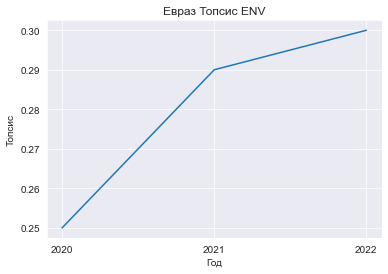

<Figure size 216x432 with 0 Axes>

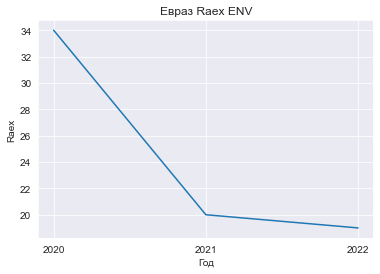

<Figure size 216x432 with 0 Axes>

In [250]:
plt.plot(y, x_e_e_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Евраз Топсис ENV') #Название
plt.figure(figsize=(3, 6))
plt.show()

plt.plot(y, x_e_e_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Евраз Raex ENV') #Название
plt.figure(figsize=(3, 6))
plt.show()

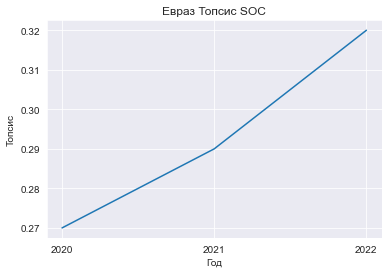

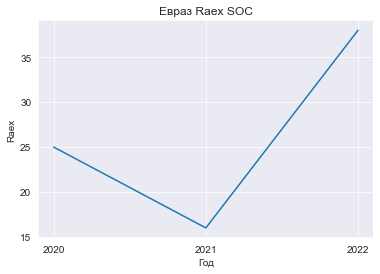

In [251]:
plt.plot(y, e_s_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Евраз Топсис SOC') #Название
plt.show()

plt.plot(y, e_s_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Евраз Raex SOC') #Название
plt.show()

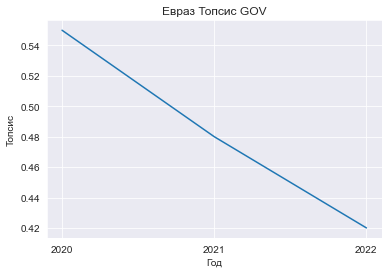

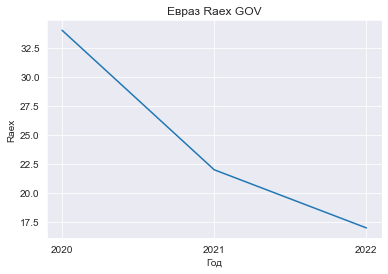

In [252]:
plt.plot(y, e_g_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Евраз Топсис GOV') #Название
plt.show()

plt.plot(y, e_g_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Евраз Raex GOV') #Название
plt.show()

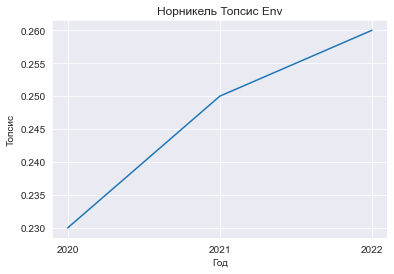

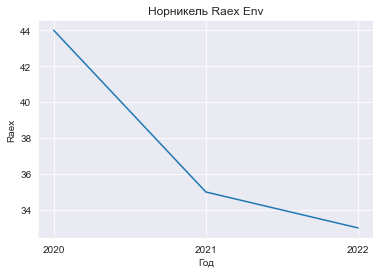

In [253]:
plt.plot(y, n_e_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Норникель Топсис Env') #Название
plt.show()

plt.plot(y, n_e_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Норникель Raex Env') #Название
plt.show()

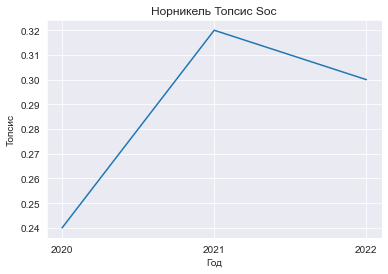

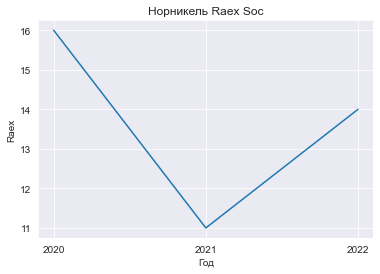

In [254]:
plt.plot(y, n_s_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Норникель Топсис Soc') #Название
plt.show()

plt.plot(y, n_s_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Норникель Raex Soc') #Название
plt.show()

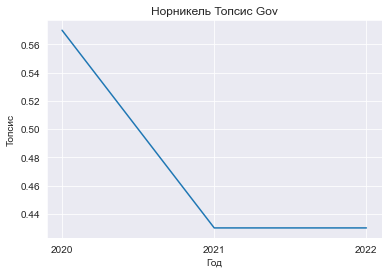

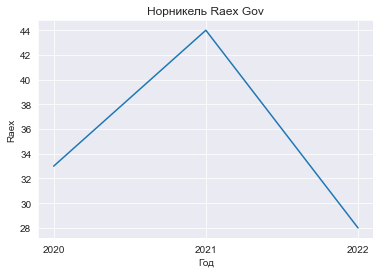

In [255]:
plt.plot(y, n_g_t)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Топсис') #Подпись для оси y
plt.title('Норникель Топсис Gov') #Название
plt.show()

plt.plot(y, n_g_r)
plt.xlabel('Год') #Подпись для оси х
plt.ylabel('Raex') #Подпись для оси y
plt.title('Норникель Raex Gov') #Название
plt.show()

In [244]:
import seaborn as sns

Другие методы: VIKOR

In [256]:
from pymcdm.methods import VIKOR

In [332]:
gr = (
    df.drop(
        columns=[
            "Unnamed: 0.1",
            "rsspp_index",
            "paragraph",
            "original_text",
            "cleaned_text",
            "max_topic_cos",
            "max_score_cos",
            "count_words",
            "second_max_topic_cos",
            "second_max_score_cos",
            "max_topic_exp",
            "max_score_exp",
            "second_max_topic_exp",
            "second_max_score_exp",
        ]
    )
    .groupby(["company", "index"])
    .mean()
    .dropna(how="all")
)
gr.head()

,,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,Экологичность продукта,...,Этика и антикоррупция_percent_of_words,Этика и антикоррупция_importance,Этика и антикоррупция_base_words_count,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words
company,index,,,,,,,,,,,,,,,,,,,,,
«Общероссийское отраслевое объединение работодателей электроэнергетики,812,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,0.003969,...,0.007856,0.004237,0.296610,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253
АО «Калининградский янтарный комбинат,505,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,0.000000,...,0.001190,0.000000,0.035714,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000
Акрон 2022,1420,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,0.012634,...,0.016739,0.107417,0.560102,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696
ВК 2022,1421,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,0.000000,...,0.005886,0.000000,0.263158,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000
ВТБ 2022,1422,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,0.004829,...,0.009178,0.034161,0.291925,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506


In [333]:
topic_words = pd.read_csv("../topic_words.csv", index_col=0)
topic_words.head()

,topic,weight,type,word
meta,,,,
env,Экология в целом,5,0,воздействие
env,Экология в целом,5,0,окружающая среда
env,Экология в целом,5,0,природа
env,Экология в целом,5,0,природоохранный
env,Экология в целом,5,0,экологический


In [334]:
topics = topic_words.groupby("meta")["topic"].apply(set)

In [335]:
gr.reset_index(inplace=True)
gr = gr.set_index("index")
gr.head()

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Этика и антикоррупция_percent_of_words,Этика и антикоррупция_importance,Этика и антикоррупция_base_words_count,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.007856,0.004237,0.296610,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.001190,0.000000,0.035714,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.016739,0.107417,0.560102,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.005886,0.000000,0.263158,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.009178,0.034161,0.291925,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506


In [336]:
def third_workflow(data: pd.DataFrame):
    matrix = data.to_numpy()
    weights = np.array([1 / matrix.shape[0]] * matrix.shape[1])
    types = np.ones(matrix.shape[1], dtype=int)
    body = VIKOR()
    predictions = [round(preference, 2) for preference in body(matrix, weights, types)]
    return predictions

In [298]:
from pymcdm.methods import TOPSIS, MABAC, COMET, SPOTIS, VIKOR
from pymcdm.methods.comet_tools import MethodExpert

In [271]:
gr[cur_topics]

,Права человека,!Кибербезопасность,Лидерство,Устойчивое развитие,Риски,Этика и антикоррупция,Отношения с инвесторами,!Инновации,Корпоративное управление,Отчетность и прозрачность
index,,,,,,,,,,
36,0.007304,0.0,0.028240,0.006174,0.019960,0.002439,0.003451,0.0,0.001689,0.027746
62,0.005205,0.0,0.095297,0.048132,0.060068,0.003409,0.001064,0.0,0.002141,0.044672
69,0.020544,0.0,0.020942,0.013841,0.033258,0.003819,0.001728,0.0,0.001981,0.025210
65,0.007859,0.0,0.024500,0.010335,0.023668,0.004188,0.002694,0.0,0.004711,0.017803
26,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
898,0.007330,0.0,0.007261,0.032087,0.010312,0.000000,0.000000,0.0,0.000000,0.012852
924,0.003182,0.0,0.034270,0.007511,0.019588,0.000000,0.004909,0.0,0.021402,0.024954
1413,0.011237,0.0,0.022417,0.016410,0.017461,0.001792,0.000813,0.0,0.001635,0.016991


In [348]:
bad = ["Кибербезопасность", "Инновации", "Персонал в целом"]
#gr["company"] = gr["company"].str.split("/").str[1]
for key, cur_topics in topics.items():
    tmp_topics = []
    for t in cur_topics:
        if t not in bad:
            tmp_topics.append(t)
        else:
            tmp_topics.append("!" + t)
    cur_topics = tmp_topics
    res = second_workflow(gr[cur_topics])
    pd.Series(res).set_axis(gr.index).to_csv(f"{key}.csv")
    gr[key] = res

In [339]:
gr

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Корпоративное управление_percent_of_words,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words,env,gov,social
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.013821,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253,0.15,0.11,0.37
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.008274,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000,0.31,0.08,0.17
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.022198,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696,0.62,0.61,0.49
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.008157,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000,0.26,0.27,0.30
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.013597,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506,0.34,0.29,0.49
1423,ГК Дело 2022,2020.0,0.010321,0.023988,0.007385,0.010542,0.014484,0.026118,0.004000,0.003592,...,0.014545,0.103506,0.517529,0.055372,0.724541,1.844741,64.865342,0.47,0.50,0.46
1424,Глобалтранс,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013696,0.000000,0.687500,0.013696,0.687500,0.687500,NaN,0.00,0.00,0.00
1,ДОМ.РФ,2020.0,0.017286,0.021443,0.024665,0.006599,0.003235,0.011253,0.003902,0.010094,...,0.012285,0.024390,0.432056,0.039406,0.445993,1.498258,65.309645,0.47,0.34,0.42
1425,Евраз 2022,2020.0,0.016879,0.015769,0.013579,0.011470,0.017937,0.021841,0.002909,0.006567,...,0.012335,0.015762,0.436077,0.034879,0.178634,1.262697,63.759091,0.55,0.42,0.48


In [340]:
bad = ["Кибербезопасность", "Инновации", "Персонал в целом"]

tmp_topics = []
for t in [v for _, val in topics.items() for v in val]:
    if t not in bad:
        tmp_topics.append(t)
    else:
        tmp_topics.append("!" + t)
cur_topics = tmp_topics
res = second_workflow(gr[cur_topics])
res = pd.Series(res).set_axis(gr.index)
gr["all_letters"] = res

In [341]:
gr

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Корпоративное управление_importance,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words,env,gov,social,all_letters
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.014831,0.555085,0.029070,0.118644,1.095339,56.382253,0.15,0.11,0.37,0.31
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.053571,0.232143,0.019962,0.160714,0.589286,40.875000,0.31,0.08,0.17,0.20
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.191816,0.693095,0.050272,0.327366,1.636829,62.062696,0.62,0.61,0.49,0.54
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.000000,0.315789,0.042298,0.578947,1.789474,52.000000,0.26,0.27,0.30,0.28
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.012422,0.470497,0.033955,0.341615,1.190994,54.995506,0.34,0.29,0.49,0.44
1423,ГК Дело 2022,2020.0,0.010321,0.023988,0.007385,0.010542,0.014484,0.026118,0.004000,0.003592,...,0.103506,0.517529,0.055372,0.724541,1.844741,64.865342,0.47,0.50,0.46,0.47
1424,Глобалтранс,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.687500,0.013696,0.687500,0.687500,NaN,0.00,0.00,0.00,0.00
1,ДОМ.РФ,2020.0,0.017286,0.021443,0.024665,0.006599,0.003235,0.011253,0.003902,0.010094,...,0.024390,0.432056,0.039406,0.445993,1.498258,65.309645,0.47,0.34,0.42,0.41
1425,Евраз 2022,2020.0,0.016879,0.015769,0.013579,0.011470,0.017937,0.021841,0.002909,0.006567,...,0.015762,0.436077,0.034879,0.178634,1.262697,63.759091,0.55,0.42,0.48,0.48


In [344]:
gr["on_letters"] = second_workflow(gr[["env", "gov", "social"]])

In [345]:
gr

,company,year,Экология в целом,Климат,Энергия,Воздух,Вода,Отходы и циклическая экономика,Биоразнообразие,Рекультивация земель,...,Корпоративное управление_base_words_count,Устойчивое развитие_percent_of_words,Устойчивое развитие_importance,Устойчивое развитие_base_words_count,total_found_words,env,gov,social,all_letters,on_letters
index,,,,,,,,,,,,,,,,,,,,,
812,«Общероссийское отраслевое объединение работо...,2020.0,0.000000,0.001132,0.007808,0.000000,0.001785,0.002792,0.000000,0.002574,...,0.555085,0.029070,0.118644,1.095339,56.382253,0.15,0.11,0.37,0.31,0.38
505,АО «Калининградский янтарный комбинат,2020.0,0.016999,0.000000,0.002343,0.005054,0.008300,0.020204,0.003690,0.005593,...,0.232143,0.019962,0.160714,0.589286,40.875000,0.31,0.08,0.17,0.20,0.30
1420,Акрон 2022,2020.0,0.016815,0.013265,0.012250,0.018161,0.016011,0.017295,0.008504,0.014006,...,0.693095,0.050272,0.327366,1.636829,62.062696,0.62,0.61,0.49,0.54,0.88
1421,ВК 2022,2020.0,0.000000,0.014066,0.013555,0.000000,0.000000,0.015784,0.000000,0.000000,...,0.315789,0.042298,0.578947,1.789474,52.000000,0.26,0.27,0.30,0.28,0.44
1422,ВТБ 2022,2020.0,0.008346,0.009851,0.008464,0.005606,0.006112,0.010215,0.007994,0.004930,...,0.470497,0.033955,0.341615,1.190994,54.995506,0.34,0.29,0.49,0.44,0.58
1423,ГК Дело 2022,2020.0,0.010321,0.023988,0.007385,0.010542,0.014484,0.026118,0.004000,0.003592,...,0.517529,0.055372,0.724541,1.844741,64.865342,0.47,0.50,0.46,0.47,0.73
1424,Глобалтранс,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.687500,0.013696,0.687500,0.687500,NaN,0.00,0.00,0.00,0.00,0.00
1,ДОМ.РФ,2020.0,0.017286,0.021443,0.024665,0.006599,0.003235,0.011253,0.003902,0.010094,...,0.432056,0.039406,0.445993,1.498258,65.309645,0.47,0.34,0.42,0.41,0.63
1425,Евраз 2022,2020.0,0.016879,0.015769,0.013579,0.011470,0.017937,0.021841,0.002909,0.006567,...,0.436077,0.034879,0.178634,1.262697,63.759091,0.55,0.42,0.48,0.48,0.74
